In [ ]:
# Load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from numpy import linalg as LA
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [ ]:
# 01. Import gene expression test result between tumour and normal samples
resLFC_LUAD = pd.read_csv('resLFC_LUAD.csv')
resLFC_LUAD.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000000003.15,3043.417527,1.105787,0.102394,10.799368,3.465825e-27,5.997817e-26
1,ENSG00000000005.6,6.698799,1.580134,0.467129,3.382653,7.178931e-04,1.566460e-03
2,ENSG00000000419.13,1519.905188,0.253888,0.076538,3.317149,9.094119e-04,1.951526e-03
3,ENSG00000000457.14,752.504754,0.477561,0.065399,7.302215,2.830688e-13,1.786317e-12
4,ENSG00000000460.17,371.355110,1.737929,0.099519,17.463258,2.729069e-68,3.622678e-66


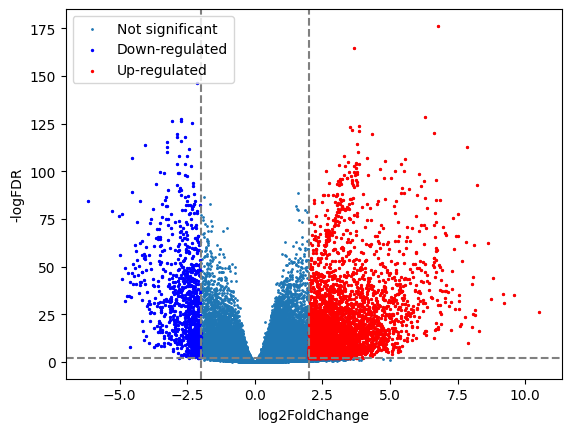

In [ ]:
# Draw volcano plot of result data
plt.scatter(x=resLFC_LUAD['log2FoldChange'],y=resLFC_LUAD['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

# highlight down- or up- regulated genes
down = resLFC_LUAD[(resLFC_LUAD['log2FoldChange']<=-2)&(resLFC_LUAD['padj']<=0.01)]
up = resLFC_LUAD[(resLFC_LUAD['log2FoldChange']>=2)&(resLFC_LUAD['padj']<=0.01)]

plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=2,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=2,label="Up-regulated",color="red")

plt.xlabel("log2FoldChange")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()
plt.show()

In [ ]:
# Filter resLFC data based on log2FoldChange and padj
resLFC_LUAD_filt = resLFC_LUAD[(resLFC_LUAD['log2FoldChange'].abs() >= 2) & (resLFC_LUAD['padj'] <= 0.01)]
resLFC_LUAD_filt

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5,ENSG00000000938.13,1344.258697,-2.107527,0.137135,-15.368232,2.673668e-53,1.870863e-51
8,ENSG00000001084.13,4285.898838,2.228747,0.215380,10.347997,4.273330e-25,6.439673e-24
20,ENSG00000002079.14,35.196221,2.901579,0.250707,11.573580,5.609215e-31,1.220640e-29
25,ENSG00000002726.21,1818.846743,4.972595,0.299167,16.621464,4.872777e-62,4.919979e-60
27,ENSG00000002746.15,81.289349,2.383939,0.190239,12.531283,5.034135e-36,1.467736e-34
...,...,...,...,...,...,...,...
54623,ENSG00000288571.1,3.471847,3.833925,0.671428,5.710109,1.129041e-08,4.590308e-08
54632,ENSG00000288581.1,0.967995,-2.182035,0.401242,-5.438204,5.382023e-08,2.035589e-07
54652,ENSG00000288611.1,35.835807,2.120865,0.317776,6.674100,2.487547e-11,1.322229e-10
54660,ENSG00000288637.1,3.638359,2.541042,0.387124,6.563898,5.241901e-11,2.710307e-10


In [ ]:
# Import label and survival data
tissue_class_data = pd.read_csv("LUAD_code.csv")
tissue_class_data.head()

,barcode,patient,shortLetterCode,days_to_last_follow_up,days_to_death
0,TCGA-73-4658-01A-01R-1755-07,TCGA-73-4658,TP,1600.0,1600.0
1,TCGA-44-2661-11A-01R-1758-07,TCGA-44-2661,NT,1159.0,NaN
2,TCGA-55-6986-11A-01R-1949-07,TCGA-55-6986,NT,3261.0,NaN
3,TCGA-55-8615-01A-11R-2403-07,TCGA-55-8615,TP,446.0,NaN
4,TCGA-97-8177-01A-11R-2287-07,TCGA-97-8177,TP,499.0,NaN


In [ ]:
# Count values of shortLetterCode in tissue_class_data
tissue_class_data['shortLetterCode'].value_counts()

,count
shortLetterCode,
TP,539
NT,59


In [ ]:
# Import the gene expression data
gene_expression_data = pd.read_csv("normalized_counts_LUAD.csv", sep=",")
gene_expression_data

,gene_id,TCGA-73-4658-01A-01R-1755-07,TCGA-44-2661-11A-01R-1758-07,TCGA-55-6986-11A-01R-1949-07,TCGA-55-8615-01A-11R-2403-07,TCGA-97-8177-01A-11R-2287-07,TCGA-49-6744-11A-01R-1858-07,TCGA-67-3771-01A-01R-0946-07,TCGA-49-6744-01A-11R-1858-07,TCGA-MP-A4SW-01A-21R-A24X-07,...,TCGA-62-A46V-01A-11R-A24H-07,TCGA-05-4250-01A-01R-1107-07,TCGA-44-2665-01A-01R-A278-07,TCGA-44-2665-01B-06R-A277-07,TCGA-50-5044-01A-21R-1858-07,TCGA-64-1678-01A-01R-0946-07,TCGA-78-7155-01A-11R-2039-07,TCGA-78-7220-01A-11R-2039-07,TCGA-80-5611-01A-01R-1628-07,TCGA-93-8067-01A-11R-2287-07
0,ENSG00000000938.13,2038.309881,3093.938452,2560.751728,686.023965,1450.396551,3694.950081,1114.561336,1428.059800,1356.044295,...,391.315973,1029.086964,292.948421,373.093052,674.471880,139.228263,201.653742,280.288302,1688.209928,484.889531
1,ENSG00000001084.13,1009.861734,924.844468,1659.551981,2221.782159,1705.903556,1062.349486,16094.413968,1324.236522,1754.117285,...,166.379000,1685.936069,404.872237,727.295317,357.551358,5460.169265,4791.143527,64196.801578,8273.034203,17414.253594
2,ENSG00000002079.14,40.890107,3.813792,9.978319,8.909402,6.939696,5.476028,12.356556,3.917860,12.115265,...,4.647458,228.530211,3.893002,47.226969,160.491803,8.071204,2.489552,10.780319,5.753953,996.414691
3,ENSG00000002726.21,66.911084,61.974114,21.006987,8285.743993,359.602451,30.118156,1147.924037,1474.094650,345.285050,...,143.141710,4092.513417,1465.715357,297.529902,148.302552,383.382173,2.489552,2670.579105,63.293487,4742.352788
4,ENSG00000002746.15,95.410250,63.881010,10.503494,41.205985,133.746876,41.070212,384.288886,57.788428,20.769026,...,142.212218,132.491442,323.119189,259.748328,83.293214,36.320416,16.182090,10.780319,32.222139,32.083827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5909,ENSG00000288571.1,0.000000,0.000000,0.000000,6.682052,1.892644,0.000000,25.948767,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,74.658634,0.000000,0.980029,0.000000,0.000000
5910,ENSG00000288581.1,0.000000,2.860344,18.906288,0.000000,0.000000,1.369007,0.000000,0.000000,3.461504,...,0.000000,0.000000,2.919752,14.168091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5911,ENSG00000288611.1,7.434565,8.581031,15.230066,4.454701,1.261763,8.214042,9.885245,11.753579,6.923009,...,10.224408,58.184072,0.973251,33.058878,2.031542,10.089005,2.489552,295.968767,4.603163,13.923170
5912,ENSG00000288637.1,3.717282,0.953448,1.575524,0.000000,1.261763,0.000000,2.471311,0.000000,7.788385,...,0.929492,1.402026,8.759255,28.336181,0.000000,0.000000,0.000000,2.940087,8.055535,1.210710


In [ ]:
# transform gene expression data
transformed_gene_data = gene_expression_data.set_index("gene_id").transpose()
transformed_gene_data.index.name = "Patient_ID"
transformed_gene_data

gene_id,ENSG00000000938.13,ENSG00000001084.13,ENSG00000002079.14,ENSG00000002726.21,ENSG00000002746.15,ENSG00000004776.13,ENSG00000004799.8,ENSG00000004939.15,ENSG00000005073.6,ENSG00000005471.19,...,ENSG00000288536.1,ENSG00000288539.1,ENSG00000288543.1,ENSG00000288549.1,ENSG00000288555.1,ENSG00000288571.1,ENSG00000288581.1,ENSG00000288611.1,ENSG00000288637.1,ENSG00000288638.1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-73-4658-01A-01R-1755-07,2038.309881,1009.861734,40.890107,66.911084,95.410250,270.122525,5419.797823,6.195471,0.000000,52.041954,...,6.195471,0.000000,7.434565,0.000000,0.000000,0.000000,0.000000,7.434565,3.717282,121.431227
TCGA-44-2661-11A-01R-1758-07,3093.938452,924.844468,3.813792,61.974114,63.881010,665.506638,3672.681330,5.720687,2.860344,43.858604,...,0.000000,3.813792,63.881010,0.000000,0.000000,0.000000,2.860344,8.581031,0.953448,0.000000
TCGA-55-6986-11A-01R-1949-07,2560.751728,1659.551981,9.978319,21.006987,10.503494,397.032056,10091.756606,8.927970,0.000000,19.431463,...,0.525175,1.050349,37.812577,0.525175,0.000000,0.000000,18.906288,15.230066,1.575524,0.000000
TCGA-55-8615-01A-11R-2403-07,686.023965,2221.782159,8.909402,8285.743993,41.205985,52.342738,3912.341216,1.113675,0.000000,670.432511,...,7.795727,0.000000,1.113675,1.113675,0.000000,6.682052,0.000000,4.454701,0.000000,0.000000
TCGA-97-8177-01A-11R-2287-07,1450.396551,1705.903556,6.939696,359.602451,133.746876,97.786631,485.778749,4.416170,6.308815,63.088149,...,1.261763,1.261763,3.785289,0.630881,0.000000,1.892644,0.000000,1.261763,1.261763,153.935084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-64-1678-01A-01R-0946-07,139.228263,5460.169265,8.071204,383.382173,36.320416,6.053403,918.099414,0.000000,0.000000,236.082707,...,0.000000,0.000000,2.017801,4.035602,2.017801,74.658634,0.000000,10.089005,0.000000,2.017801
TCGA-78-7155-01A-11R-2039-07,201.653742,4791.143527,2.489552,2.489552,16.182090,26.140300,555.170177,3.734329,105.805976,7.468657,...,0.000000,1.244776,3.734329,1.244776,0.000000,0.000000,0.000000,2.489552,0.000000,7.468657
TCGA-78-7220-01A-11R-2039-07,280.288302,64196.801578,10.780319,2670.579105,10.780319,49.981481,2765.641921,0.980029,121.523600,24.500726,...,0.980029,0.000000,1.960058,2.940087,0.000000,0.980029,0.000000,295.968767,2.940087,1.960058


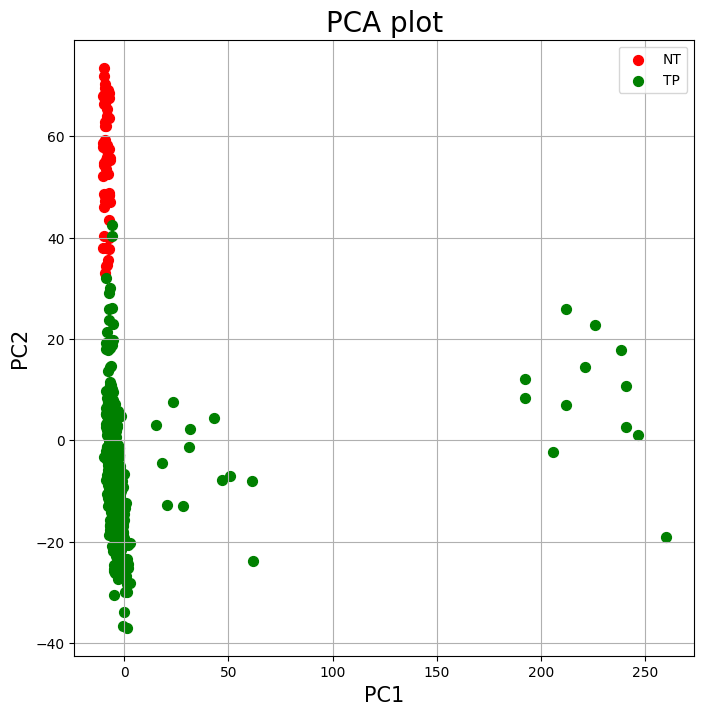

In [ ]:
# PCA plot based on DEGs
X = transformed_gene_data
# Scale gene expression data
scaler = StandardScaler()
X_scl = scaler.fit_transform(X)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scl)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, tissue_class_data["shortLetterCode"]], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA plot', fontsize = 20)

targets = ['NT', "TP"]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['shortLetterCode'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Feature Selection using Lasso

In [ ]:
# Feature selection using Lasso
# Set barcode as index
tissue_class_data['Class'] = np.where(tissue_class_data['shortLetterCode'] == 'TP', 1, 0)
tissue_class_data_1 = tissue_class_data.set_index("barcode")
tissue_class_data_1 = tissue_class_data_1[["Class"]]
tissue_class_data_1

,Class
barcode,
TCGA-73-4658-01A-01R-1755-07,1
TCGA-44-2661-11A-01R-1758-07,0
TCGA-55-6986-11A-01R-1949-07,0
TCGA-55-8615-01A-11R-2403-07,1
TCGA-97-8177-01A-11R-2287-07,1
...,...
TCGA-64-1678-01A-01R-0946-07,1
TCGA-78-7155-01A-11R-2039-07,1
TCGA-78-7220-01A-11R-2039-07,1


In [ ]:
# Assign gene expression data and class data to X and y
X = transformed_gene_data.values
y = tissue_class_data_1.values
# Split the data into test set and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (478, 5914)
Shape of Test Features: (120, 5914)
Shape of Train Target: (478, 1)
Shape of Test Target: (120, 1)


In [ ]:
# Oversampling
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train) # only apply SMOTE on training data so it will not affect the test data

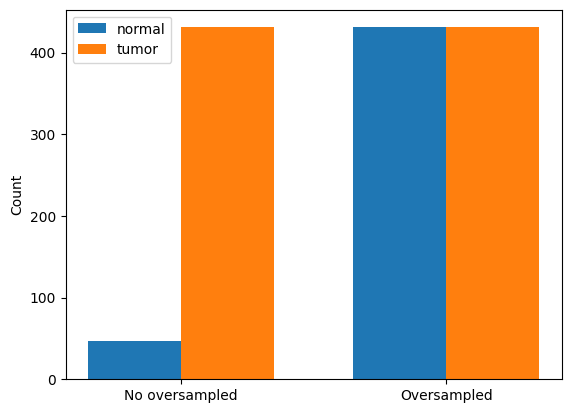

In [ ]:
y_train = y_train.flatten()
# Draw number of training data before and after oversampling
counts1 = [np.sum(y_train == 0), np.sum(y_train == 1)]
counts2 = [np.sum(y_train_oversampled == 0), np.sum(y_train_oversampled == 1)]

# Labels and positions
labels = ['No oversampled', 'Oversampled']
x = np.arange(len(labels))

# Plot
width = 0.35  # Width of bars
fig, ax = plt.subplots()
bar1 = ax.bar(x - width / 2, counts1, width, label='normal')
bar2 = ax.bar(x + width / 2, counts2, width, label='tumor')

# Add labels, title, and legend
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig("Oversampled.png")

In [ ]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# range of alpha values
params = {'alpha': np.logspace(-4, 1, 100)}
# 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Lasso model
lasso = Lasso(max_iter=50000)

# GridSearchCV --> best alpha
lasso_cv = GridSearchCV(lasso, param_grid=params, cv=kf, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train_oversampled)

# Print best alpha
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best Alpha: {best_alpha}")

Best Alpha: 0.001023531021899027


In [ ]:
best_alpha = 0.001023531021899027

In [ ]:
# Fit the Lasso model with the best alpha
lasso_best = Lasso(alpha= best_alpha, max_iter=50000)
lasso_best.fit(X_train_scaled, y_train_oversampled)

Lasso(alpha=0.001023531021899027, max_iter=50000)

In [ ]:
# Using np.abs() to make coefficients positive.
lasso1_coef = np.abs(lasso_best.coef_)
threshold = 0.01  # Threshold for lasso coeficient
names=transformed_gene_data.columns # names of genes
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected genes: {}".format(feature_subset))
print(len(feature_subset))
# Change np array to panda table
selected_genes_lasso = pd.DataFrame(feature_subset, columns=['gene_id'])
# Save
selected_genes_lasso.to_csv("selected_genes_lasso.csv", index=False)

Selected genes: ['ENSG00000007402.12' 'ENSG00000011201.12' 'ENSG00000034971.17'
 'ENSG00000064195.7' 'ENSG00000065618.21' 'ENSG00000079462.8'
 'ENSG00000081277.13' 'ENSG00000088882.8' 'ENSG00000101180.16'
 'ENSG00000101307.16' 'ENSG00000101441.4' 'ENSG00000102313.9'
 'ENSG00000102683.8' 'ENSG00000105971.15' 'ENSG00000106038.13'
 'ENSG00000106178.7' 'ENSG00000106341.11' 'ENSG00000107159.13'
 'ENSG00000115297.11' 'ENSG00000116014.10' 'ENSG00000116711.10'
 'ENSG00000116981.3' 'ENSG00000117834.13' 'ENSG00000117983.17'
 'ENSG00000121335.12' 'ENSG00000121742.19' 'ENSG00000124003.13'
 'ENSG00000127928.13' 'ENSG00000128849.11' 'ENSG00000132671.6'
 'ENSG00000133800.9' 'ENSG00000134160.14' 'ENSG00000134256.12'
 'ENSG00000135063.19' 'ENSG00000135917.16' 'ENSG00000136929.13'
 'ENSG00000137976.7' 'ENSG00000138669.9' 'ENSG00000138722.10'
 'ENSG00000140465.14' 'ENSG00000140505.7' 'ENSG00000143858.12'
 'ENSG00000145832.14' 'ENSG00000147255.19' 'ENSG00000152254.11'
 'ENSG00000154975.14' 'ENSG0000015591

Feature Selection using Random Forest

In [ ]:
# Load library
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Hyperparameter Tuning with GridSearchCV for random forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_oversampled, y_train_oversampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [ ]:
# Best parameters from grid search
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Step 7: Train Random Forest Classifier with Best Parameters
rf_best = grid_search.best_estimator_
rf_best.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate Model Performance
from sklearn.metrics import classification_report
y_pred = rf_best.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.99      0.99      0.99       108

    accuracy                           0.98       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.98      0.98      0.98       120



In [ ]:
# Step 9: Extract Feature Importances
feature_importances = rf_best.feature_importances_
important_genes = pd.DataFrame({
    'gene': transformed_gene_data.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

In [ ]:
# Save or display the top genes
top_genes = important_genes[important_genes['importance'] > 0.003]
top_genes.to_csv("top_genes.csv", index=False)
print(top_genes)

                    gene  importance
2584   ENSG00000224215.1    0.038943
107   ENSG00000070778.13    0.028759
713   ENSG00000134115.13    0.028686
1114   ENSG00000158764.7    0.028490
1297  ENSG00000166123.14    0.028323
...                  ...         ...
706    ENSG00000133800.9    0.008316
528   ENSG00000122852.15    0.008232
459   ENSG00000116194.13    0.008217
954   ENSG00000147257.15    0.008170
3954   ENSG00000250899.3    0.007887

[75 rows x 2 columns]


Feature selection using Relief Method

In [ ]:
!pip install skrebate
from skrebate import ReliefF

  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29256 sha256=3d7e8bf0ce594b9755cb789c5984de06448ce6a33fbe0e2d0abcfdcad805c7b5
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built skrebate


In [100]:
# Function to select features using ReliefF
def select_features_relief(X, y, num_features, feature_names):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply ReliefF feature selection
    relieff = ReliefF(n_features_to_select=num_features, n_neighbors=10)
    relieff.fit(X_scaled, y)

    # Get feature importance scores
    feature_scores = relieff.feature_importances_

    # Select top features
    selected_feature_indices = np.argsort(feature_scores)[::-1][:num_features]
    selected_features = [feature_names[i] for i in selected_feature_indices]  # Map indices to gene IDs

    return selected_features

X = transformed_gene_data.values  # Gene expression matrix
y = tissue_class_data_1['Class'].values  # Class labels

# Get gene IDs (column names in transformed_gene_data)
gene_ids = transformed_gene_data.columns

# Oversample training data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Select features and output their IDs
num_features_to_select = 200  # Adjust this to the desired number of features
selected_gene_ids = select_features_relief(X_resampled, y_resampled, num_features_to_select, gene_ids)

print(f"Top {num_features_to_select} selected gene IDs:")
print(selected_gene_ids)

Top 200 selected gene IDs:
['ENSG00000171885.18', 'ENSG00000261863.1', 'ENSG00000138821.13', 'ENSG00000078081.8', 'ENSG00000122852.15', 'ENSG00000123119.12', 'ENSG00000168484.12', 'ENSG00000274736.5', 'ENSG00000206177.7', 'ENSG00000168481.9', 'ENSG00000158578.21', 'ENSG00000185303.17', 'ENSG00000197415.12', 'ENSG00000250978.5', 'ENSG00000167972.14', 'ENSG00000167261.14', 'ENSG00000115361.8', 'ENSG00000239839.7', 'ENSG00000171611.10', 'ENSG00000197465.14', 'ENSG00000135604.10', 'ENSG00000140932.10', 'ENSG00000112137.18', 'ENSG00000224397.7', 'ENSG00000276668.1', 'ENSG00000031081.11', 'ENSG00000128849.11', 'ENSG00000249741.2', 'ENSG00000165197.5', 'ENSG00000275612.1', 'ENSG00000234281.5', 'ENSG00000105974.13', 'ENSG00000112782.19', 'ENSG00000213853.10', 'ENSG00000170909.13', 'ENSG00000234506.5', 'ENSG00000261371.6', 'ENSG00000168497.5', 'ENSG00000227508.6', 'ENSG00000277758.5', 'ENSG00000154721.15', 'ENSG00000141338.14', 'ENSG00000172159.16', 'ENSG00000007402.12', 'ENSG00000204305.14', '

In [101]:
# Save selected genes to CSV
output_file = "selected_genes.csv"
relief_selected_genes = pd.DataFrame(selected_gene_ids, columns=["Gene_ID"])
relief_selected_genes.to_csv(output_file, index=False)

In [105]:
# Combine 3 selected gene set
lasso_genes = pd.read_csv("selected_genes_lasso.csv")
rf_genes = pd.read_csv("top_genes.csv")
rl_genes = pd.read_csv("selected_genes.csv")

In [106]:
# Get unique genes from 3 dfs
union_genes = set(lasso_genes["gene_id"]) | set(rf_genes["gene"]) | set(rl_genes["Gene_ID"])
len(union_genes)

413

In [107]:
# Filter gene expression dataset to keep only the genes in union gene set
selected_gene_expression_data = transformed_gene_data.loc[:, transformed_gene_data.columns.isin(list(union_genes))]
selected_gene_expression_data

gene_id,ENSG00000000938.13,ENSG00000004939.15,ENSG00000007402.12,ENSG00000008300.17,ENSG00000011201.12,ENSG00000019169.10,ENSG00000022267.19,ENSG00000025423.11,ENSG00000031081.11,ENSG00000034971.17,...,ENSG00000286256.2,ENSG00000286646.1,ENSG00000286662.2,ENSG00000286919.1,ENSG00000287010.1,ENSG00000287035.1,ENSG00000287641.1,ENSG00000287652.1,ENSG00000287784.1,ENSG00000287879.1
Patient_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-73-4658-01A-01R-1755-07,2038.309881,6.195471,257.731584,648.046242,1812.794745,2642.987827,2190.718461,747.173774,2319.584253,9.912753,...,12.390942,142.495828,1.239094,6.195471,0.000000,1.239094,0.000000,2.478188,2.478188,16.108224
TCGA-44-2661-11A-01R-1758-07,3093.938452,5.720687,11761.733357,77.229280,13258.646568,20447.643772,16792.124504,3346.602147,8248.277827,150.644769,...,62.927562,348.961933,0.000000,0.000000,0.953448,1.906896,0.953448,6.674135,2.860344,6.674135
TCGA-55-6986-11A-01R-1949-07,2560.751728,8.927970,7409.164353,79.826551,9795.558088,7552.537040,16544.577871,2650.031424,5788.475297,110.811857,...,43.589498,107.135634,0.000000,0.000000,0.000000,0.000000,0.525175,16.280415,19.956638,1.050349
TCGA-55-8615-01A-11R-2403-07,686.023965,1.113675,3961.342928,240.553858,126.958981,1690.559057,135.868383,198.234198,393.127370,1.113675,...,13.364103,31.182907,0.000000,3.341026,0.000000,0.000000,0.000000,0.000000,0.000000,3.341026
TCGA-97-8177-01A-11R-2287-07,1450.396551,4.416170,1960.148797,82.014594,1864.885692,4710.792105,1073.760300,3035.170860,1713.474134,1.261763,...,20.188208,103.464565,0.000000,8.832341,0.000000,1.261763,0.000000,1.261763,0.000000,1.261763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-64-1678-01A-01R-0946-07,139.228263,0.000000,579.108861,332.937150,411.631386,96.854444,157.388471,1002.847053,133.174860,0.000000,...,4.035602,10.089005,8.071204,2.017801,0.000000,0.000000,0.000000,0.000000,0.000000,12.106805
TCGA-78-7155-01A-11R-2039-07,201.653742,3.734329,32.364181,1341.868725,3080.821052,92.113438,351.026883,1588.334409,1664.265756,1.244776,...,1.244776,8.713433,1.244776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.447762
TCGA-78-7220-01A-11R-2039-07,280.288302,0.980029,208.746183,597.817708,258.727664,362.610741,486.094399,112.703338,746.782120,1.960058,...,7.840232,25.480755,0.980029,1.960058,0.000000,0.980029,0.000000,1.960058,0.980029,8.820261


Machine Learning model to classify tumor and normal samples

KNN model

In [108]:
# 01. KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [109]:
# Separate features (X) and target variable (y)
X = selected_gene_expression_data.values
y = np.asarray(tissue_class_data["Class"])


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# KNN model
# Normalize the feature data for KNN
scaler = StandardScaler()
X_train_oversampled = scaler.fit_transform(X_train_oversampled)
X_test = scaler.transform(X_test)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors as needed
knn.fit(X_train_oversampled, y_train_oversampled)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9916666666666667


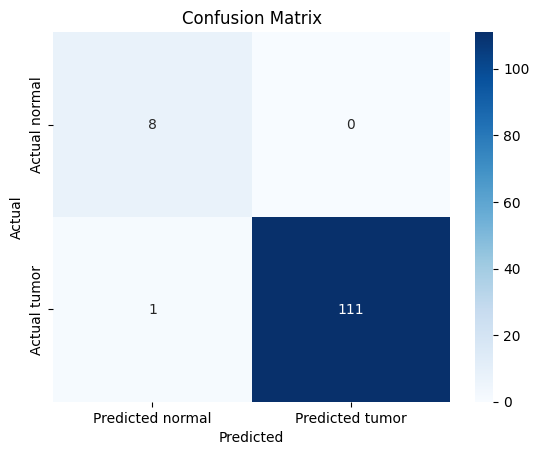

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted normal', 'Predicted tumor'],
            yticklabels=['Actual normal', 'Actual tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

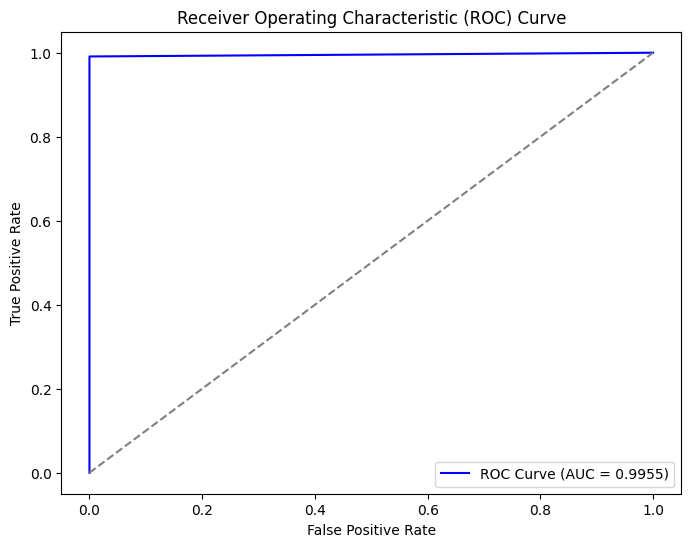

In [111]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for KNN
y_pred_proba_binary = knn.predict_proba(X_test)[:, 1]  # Use the positive class probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

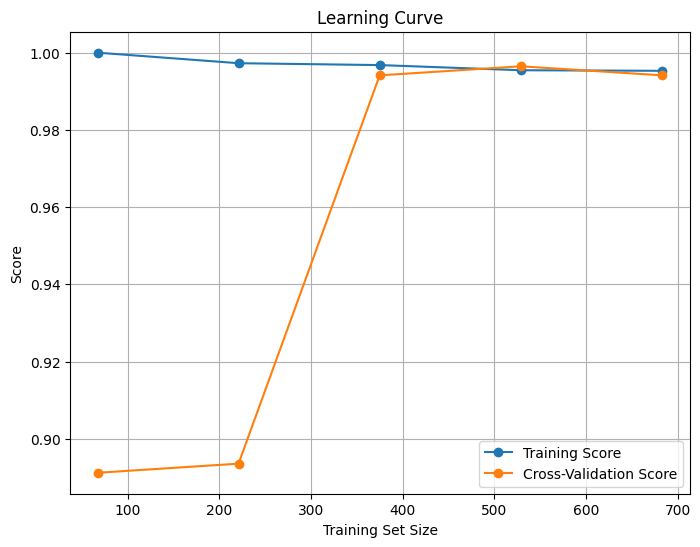

In [112]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(knn, X_train_oversampled, y_train_oversampled, cv=5)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Cross-Validation Score", marker='o')
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

CNN model

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape

In [114]:
# Split the data into test set and training set
X = selected_gene_expression_data.values
y = np.asarray(tissue_class_data["Class"])

# Split data into test set and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Oversampling data using SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train) # only apply SMOTE on training data so it will not affect the test data
print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (478, 413)
Shape of Test Features: (120, 413)
Shape of Train Target: (478,)
Shape of Test Target: (120,)


In [115]:
# 02. CNN
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

# Reshaping the data to 2D
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [116]:
# Building the CNN model
model = Sequential([
    Reshape((X_train_scaled.shape[1], 1, 1), input_shape=(X_train_scaled.shape[1], 1)),
    Conv2D(32, kernel_size=(1, 1), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [117]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)                  │ (None, 413, 1, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 413, 1, 32)          │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 13216)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         845,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 846,017 (3.23 MB)

 Trainable params: 846,017 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
history = model.fit(X_train_cnn, y_train_oversampled, epochs=50, batch_size=32, validation_split=0.3)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8890 - loss: 0.1454 - val_accuracy: 1.0000 - val_loss: 7.8004e-06
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9953 - loss: 0.0161 - val_accuracy: 1.0000 - val_loss: 4.7660e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.2657e-04 - val_accuracy: 1.0000 - val_loss: 1.9314e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.9134e-04 - val_accuracy: 1.0000 - val_loss: 8.0271e-05
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2287e-05 - val_accuracy: 1.0000 - val_loss: 5.5620e-05
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5986e-05 - val_accuracy: 1.0000 - val_loss: 4.1408e-05
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4868e-05 - val_accuracy: 1.0000 - val_loss: 3.4888e-05
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 

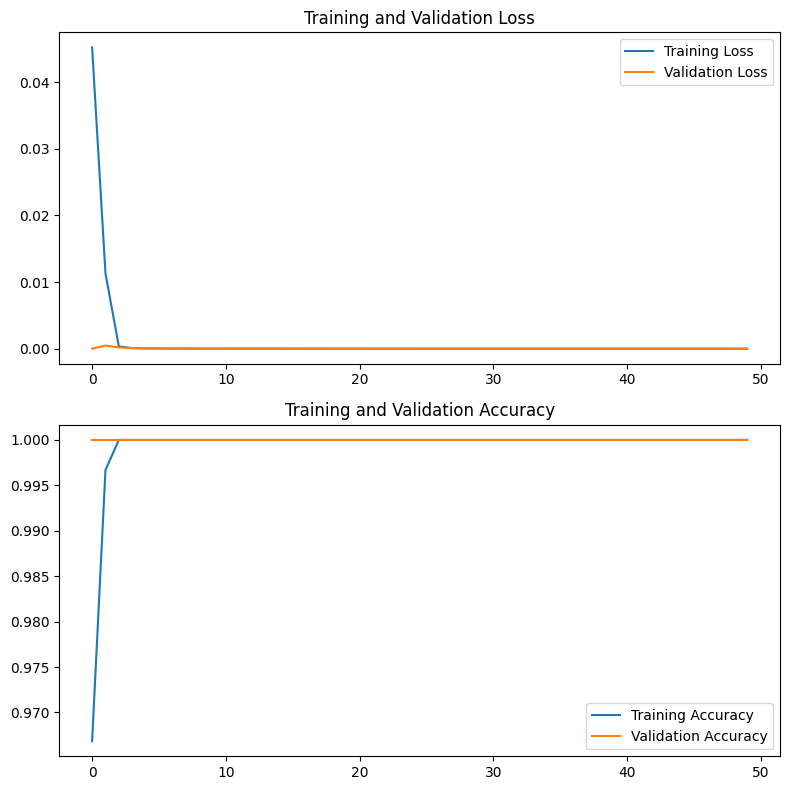

In [120]:
# Training Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Training accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Create a single figure with two subplots
plt.figure(figsize=(8, 8))

# Subplot 1: Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Subplot 2: Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the combined plot
plt.savefig("training_accuracy_loss.png", dpi=300)

In [121]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0497     
Test Loss: 0.07641054689884186
Test Accuracy: 0.9916666746139526


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


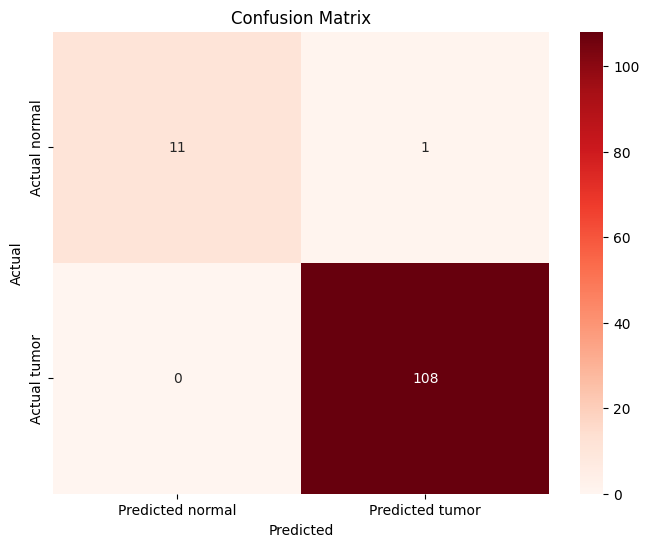

In [123]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_cnn)
y_pred_classes = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicted normal', 'Predicted tumor'],
            yticklabels=['Actual normal', 'Actual tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("confusion_matrix.png", dpi=300)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


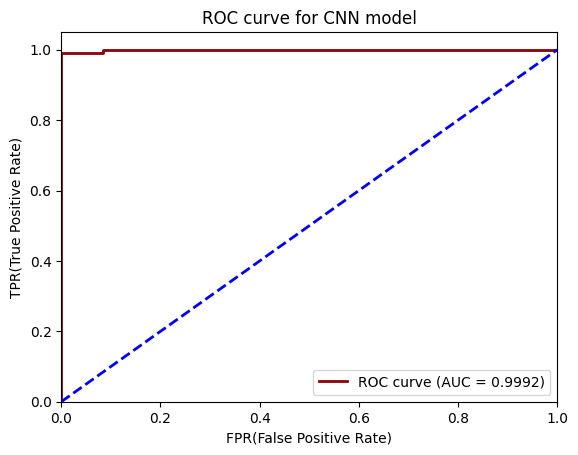

In [124]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# y_predict probability
y_pred_prob = model.predict(X_test_cnn)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkred', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR(False Positive Rate)')
plt.ylabel('TPR(True Positive Rate)')
plt.title('ROC curve for CNN model')
plt.legend(loc="lower right")
plt.savefig("roc_curve.png", dpi=300)

Random Forest Model

In [125]:
# Train-Test Split
# Separate features (X) and target variable (y)
X = selected_gene_expression_data.values
y = np.asarray(tissue_class_data["Class"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Oversample training data with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest Classifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [129]:
# Step 8: Evaluate the best model
rf_best = grid_search.best_estimator_
y_pred = rf_best.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.99      0.99      0.99       162

    accuracy                           0.99       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.99      0.99      0.99       180



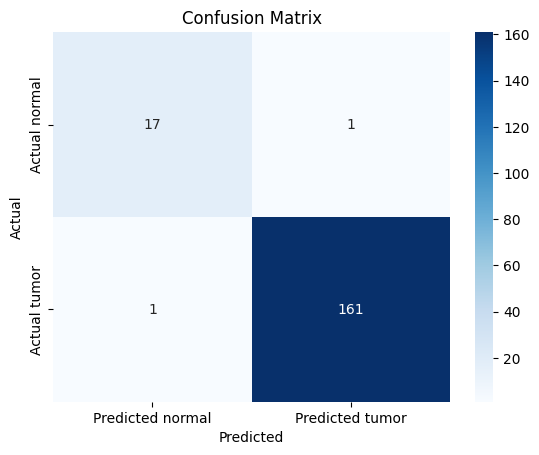

In [130]:
# Draw Confusion matrix for random forest model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted normal', 'Predicted tumor'],
            yticklabels=['Actual normal', 'Actual tumor'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


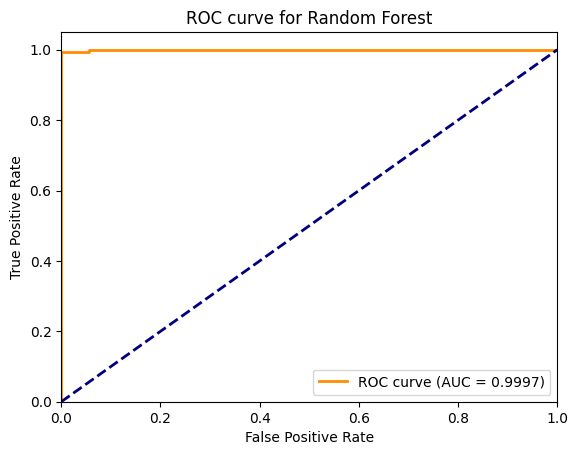

In [131]:
# Compute ROC curve and ROC area for Random Forest
y_pred_prob = rf_best.predict_proba(X_test)[:, 1] # probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest')
plt.legend(loc="lower right")
plt.show()